# Image classification

In [1]:
import time
from collections import OrderedDict

import numpy as np
import torch
import torchvision
from IPython.display import display
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid

In [2]:
labels = [
    'top', 'trousers', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [3]:
data = torchvision.datasets.FashionMNIST(
    root='../data/fashion-mnist', train=True, download=True)
train_x, val_x, train_y, val_y = train_test_split(
    np.array(data.data), np.array(data.targets), test_size=5000, random_state=1234)

data = torchvision.datasets.FashionMNIST(
    root='../data/fashion-mnist', train=False, download=True)
test_x = np.array(data.data)
test_y = np.array(data.targets)

In [4]:
data = OrderedDict()
for name, y in (('training', train_y), ('validation', val_y), ('test', test_y)):
    _, counts = np.unique(y, return_counts=True)
    data[f'{name} set'] = OrderedDict([(labels[i], c) for i, c in enumerate(counts)])
    data[f'{name} set']['total'] = y.shape[0]
display(DataFrame(data).T)

,top,trousers,pullover,dress,coat,sandal,shirt,sneaker,bag,ankle boot,total
training set,5513,5500,5502,5518,5463,5486,5470,5484,5547,5517,55000
validation set,487,500,498,482,537,514,530,516,453,483,5000
test set,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,10000


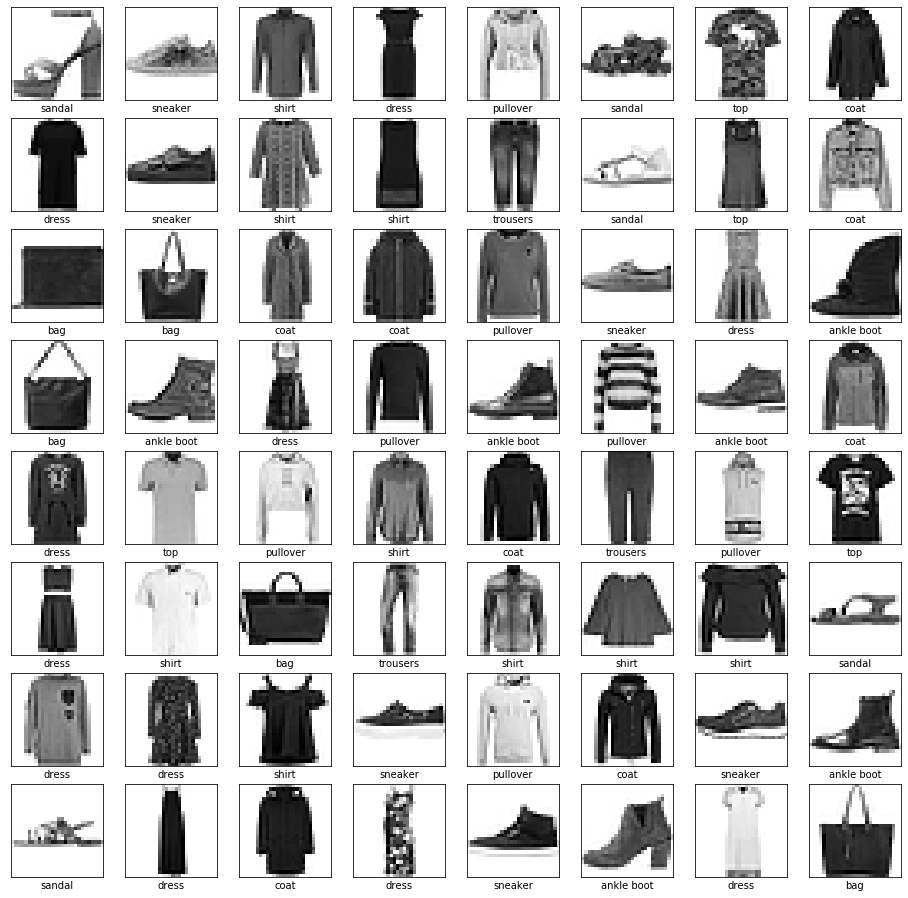

In [5]:
plt.figure(figsize=(16, 16))
for i in range(8**2):
    plt.subplot(8, 8, i + 1)
    plt.imshow(val_x[i], cmap=plt.cm.binary)
    plt.xlabel(labels[val_y[i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

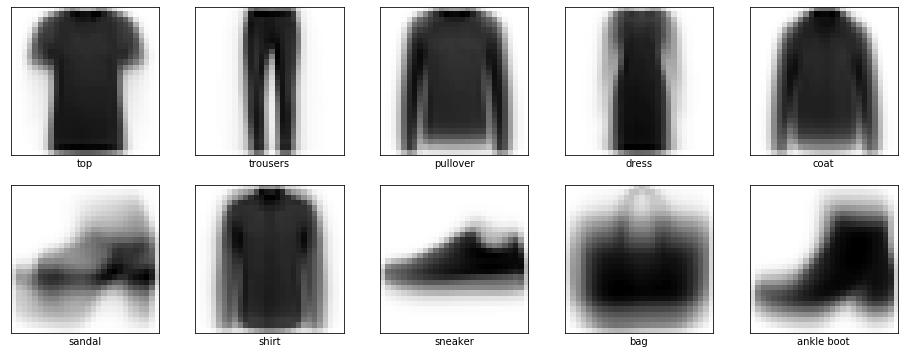

In [6]:
centroids = [(l, train_x[train_y == i].mean(axis=0)) for i, l in enumerate(labels)]
plt.figure(figsize=(16, 6))
for i, (label, image) in enumerate(centroids):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(label)
    plt.xticks([])
    plt.yticks([])
plt.show()

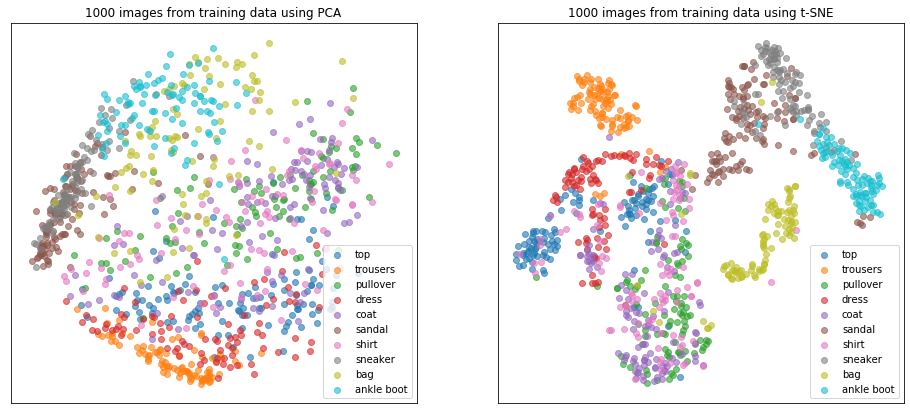

In [7]:
plt.figure(figsize=(16, 7))
for i, (name, alg) in enumerate([
        ('PCA', PCA(n_components=2)), ('t-SNE', TSNE(n_components=2))]):
    x_reduced = alg.fit_transform(train_x[:1000].reshape(-1, 784))
    y_reduced = train_y[:1000]
    data = [(l, x_reduced[y_reduced == i]) for i, l in enumerate(labels)]
    plt.subplot(1, 2, i + 1)
    for label, points in data:
        plt.scatter(points[:, 0], points[:, 1], alpha=0.6, label=label)
    plt.title(f'1000 images from training data using {name}')
    plt.legend()
    plt.xticks([])
    plt.yticks([])
plt.show()

In [8]:
def plot_history(history):
    plt.figure(figsize=(16, 5))
    for i, (name, key) in enumerate([('accuracy', 'acc'), ('loss', 'loss')]):
        plt.subplot(1, 2, i + 1)
        plt.plot(history['epoch'], history[key], label=f'training {name}')
        plt.plot(history['epoch'], history[f'val_{key}'], label=f'validation {name}')
        plt.title(f'{name} during training')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel(name)
    plt.show()

def plot_predictions(y_pred, y=val_y, x=val_x, labels=labels):
    plt.figure(figsize=(16, 18))
    for i in range(8**2):
        plt.subplot(8, 8, i + 1)
        plt.imshow(x[i], cmap=plt.cm.binary)
        plt.xlabel(
            f'pred: {labels[y_pred[i]]}\ntrue: {labels[y[i]]}',
            color='green' if y_pred[i] == y[i] else 'red')
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [9]:
train_y_preds = OrderedDict()
val_y_preds = OrderedDict()
test_y_preds = OrderedDict()

In [10]:
class SKLearnClassifier:

    def __init__(self, model):
        self.model = model

    def fit(self, train_x, train_y):
        start = time.time()
        self.model.fit(train_x.reshape(train_x.shape[0], -1), train_y)
        print(f'Finished training in {time.time() - start:.2f}s')

    def predict(self, x):
        return self.model.predict(x.reshape(x.shape[0], -1))

In [11]:
model = SKLearnClassifier(NearestCentroid(metric='euclidean'))
model.fit(train_x, train_y)

Finished training in 0.05s


In [12]:
train_y_preds['nearest centroid'] = model.predict(train_x)
val_y_preds['nearest centroid'] = model.predict(val_x)
test_y_preds['nearest centroid'] = model.predict(test_x)

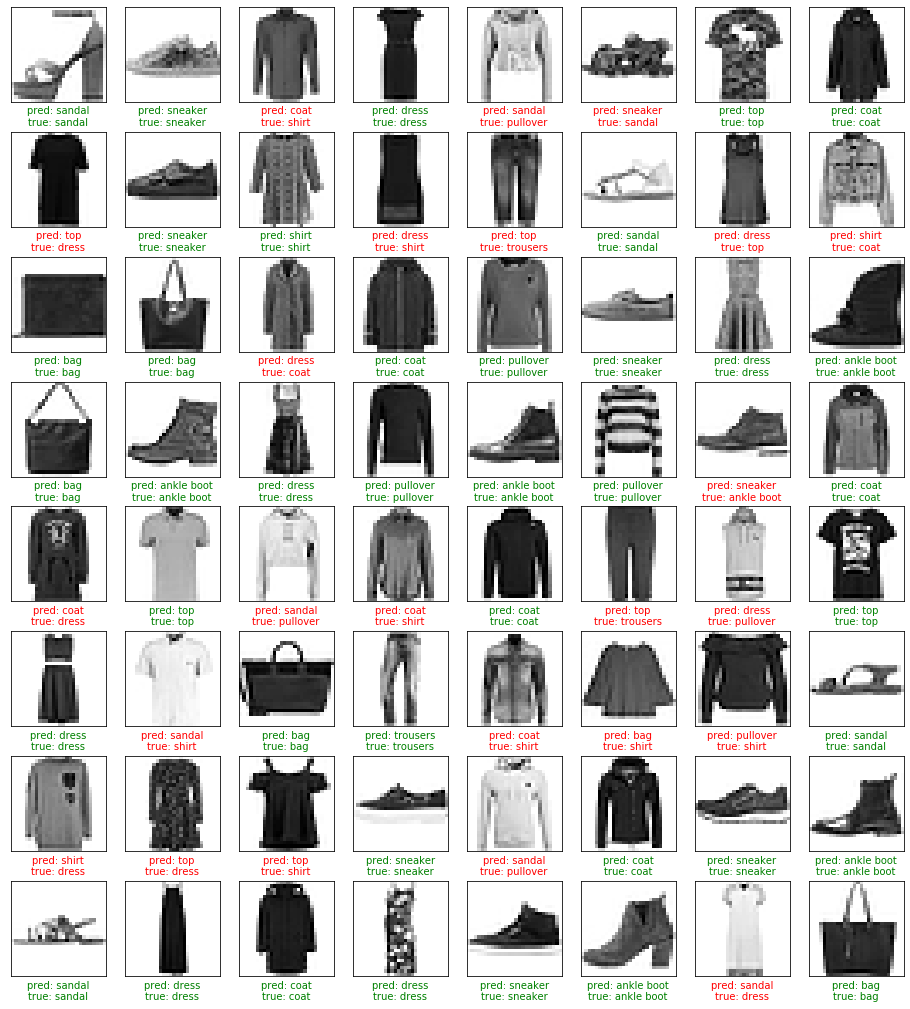

In [13]:
plot_predictions(val_y_preds['nearest centroid'])

In [14]:
model = SKLearnClassifier(
    RandomForestClassifier(n_estimators=50, max_depth=25, n_jobs=-1))
model.fit(train_x, train_y)

Finished training in 6.84s


In [15]:
train_y_preds['random forest'] = model.predict(train_x)
val_y_preds['random forest'] = model.predict(val_x)
test_y_preds['random forest'] = model.predict(test_x)

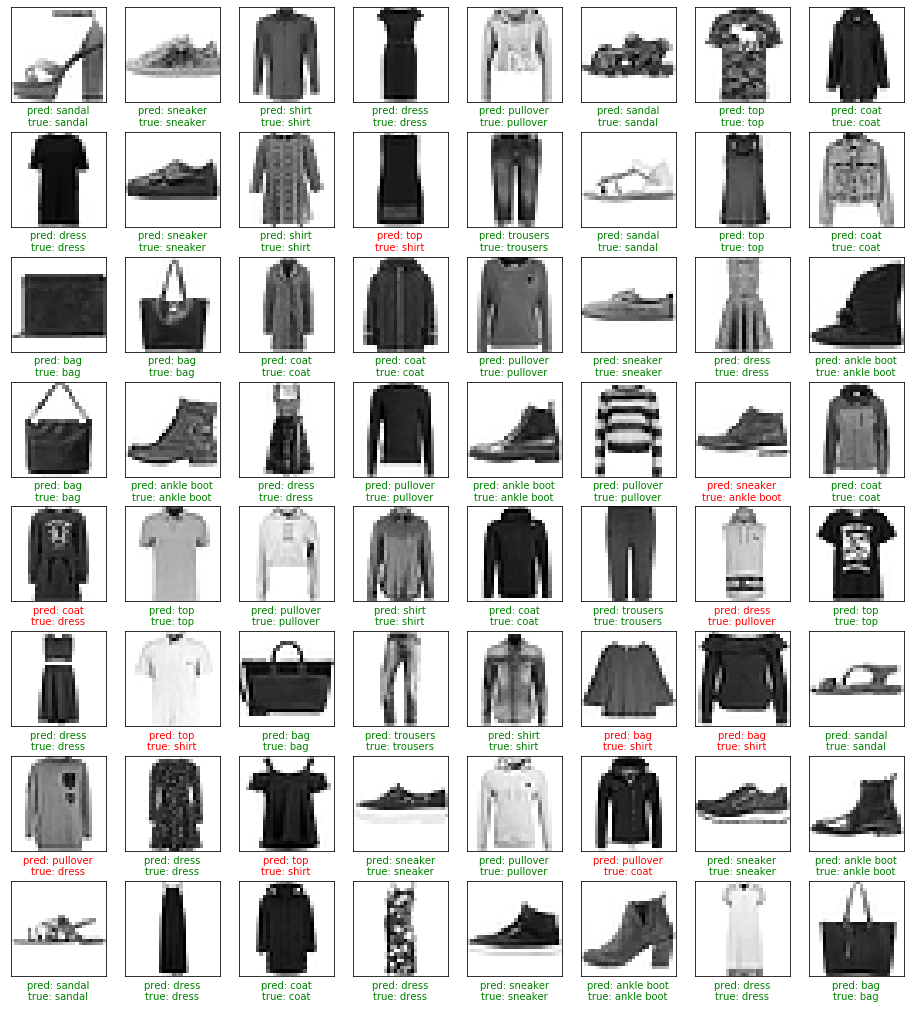

In [16]:
plot_predictions(val_y_preds['random forest'])

In [17]:
class PyTorchClassifier(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def fit(self, train_x, train_y, val_x, val_y, epochs=50, batch_size=250):
        self.to(self.device)
        train_loader = self._build_loader_xy(
            train_x, train_y, batch_size=batch_size, shuffle=True)
        val_loader = self._build_loader_xy(val_x, val_y, batch_size=1000, shuffle=False)
        history = {'epoch': [], 'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}
        for epoch in range(1, epochs+1):
            self.train()
            start_time = time.time()
            loss, acc = 0, 0
            for x, y in train_loader:
                # Batch training step
                self.optimizer.zero_grad()
                x, y = x.to(self.device), y.to(self.device)
                y_pred = self(x)
                loss_ = self.loss(y_pred, y)
                loss_.backward()
                self.optimizer.step()
                # Calculate metrics for batch
                loss += float(loss_) * len(x)
                acc += int((y_pred.argmax(dim=1) == y).sum())
            # Calculate metrics for epoch
            loss /= len(train_loader.dataset)
            acc /= len(train_loader.dataset)
            val_loss, val_acc = self._evaluate(val_loader)
            duration = time.time() - start_time
            # Save training history
            history['epoch'].append(epoch)
            history['loss'].append(loss)
            history['acc'].append(acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            print(
                f'[{epoch:{len(str(epochs))}}/{epochs}] {duration:.1f}s'
                f' - loss: {loss:.4f} - acc: {acc:.4f}'
                f' - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}')
        return history

    def predict(self, x, batch_size=1000):
        self.to(self.device)
        data_loader = self._build_loader_x(x, batch_size=batch_size, shuffle=False)
        self.eval()
        preds = []
        with torch.no_grad():
            for x, in data_loader:
                x = x.to(self.device)
                preds.extend(self(x).argmax(dim=1).cpu())
        return np.array(preds)

    def _evaluate(self, data_loader):
        self.to(self.device)
        self.eval()
        loss, acc = 0, 0
        with torch.no_grad():
            for x, y in data_loader:
                x, y = x.to(self.device), y.to(self.device)
                y_pred = self(x)
                loss += float(self.loss(y_pred, y)) * len(x)
                acc += int((y_pred.argmax(dim=1) == y).sum())
        loss /= len(data_loader.dataset)
        acc /= len(data_loader.dataset)
        return loss, acc

    @staticmethod
    def _build_loader_x(x, batch_size, shuffle):
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.FloatTensor(x) / 255),
            batch_size=batch_size, shuffle=shuffle)

    @staticmethod
    def _build_loader_xy(x, y, batch_size, shuffle):
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.FloatTensor(x) / 255, torch.LongTensor(y)),
            batch_size=batch_size, shuffle=shuffle)

In [18]:
class MultilayerPerceptron(PyTorchClassifier):

    def __init__(self):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Dropout(0.25),
            torch.nn.Linear(784, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(150, 10),
        ])
        
        self.loss = torch.nn.functional.cross_entropy
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [19]:
model = MultilayerPerceptron()
history = model.fit(train_x, train_y, val_x, val_y)

[ 1/50] 1.0s - loss: 0.7527 - acc: 0.7404 - val_loss: 0.5213 - val_acc: 0.8198
[ 2/50] 0.8s - loss: 0.5060 - acc: 0.8205 - val_loss: 0.4421 - val_acc: 0.8432
[ 3/50] 0.8s - loss: 0.4633 - acc: 0.8328 - val_loss: 0.4187 - val_acc: 0.8436
[ 4/50] 0.8s - loss: 0.4350 - acc: 0.8418 - val_loss: 0.3930 - val_acc: 0.8576
[ 5/50] 0.8s - loss: 0.4187 - acc: 0.8470 - val_loss: 0.3761 - val_acc: 0.8614
[ 6/50] 0.8s - loss: 0.4046 - acc: 0.8528 - val_loss: 0.3601 - val_acc: 0.8694
[ 7/50] 0.7s - loss: 0.3899 - acc: 0.8588 - val_loss: 0.3555 - val_acc: 0.8662
[ 8/50] 0.7s - loss: 0.3821 - acc: 0.8616 - val_loss: 0.3457 - val_acc: 0.8722
[ 9/50] 0.8s - loss: 0.3741 - acc: 0.8630 - val_loss: 0.3466 - val_acc: 0.8742
[10/50] 0.7s - loss: 0.3688 - acc: 0.8636 - val_loss: 0.3420 - val_acc: 0.8748
[11/50] 0.7s - loss: 0.3643 - acc: 0.8672 - val_loss: 0.3399 - val_acc: 0.8776
[12/50] 0.7s - loss: 0.3560 - acc: 0.8687 - val_loss: 0.3294 - val_acc: 0.8796
[13/50] 0.8s - loss: 0.3501 - acc: 0.8708 - val_loss

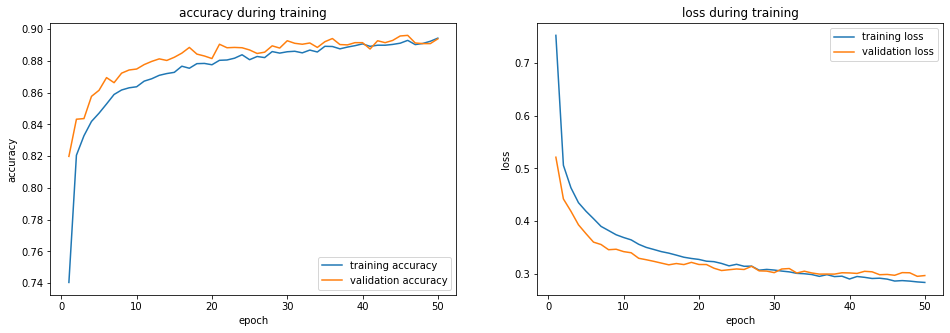

In [20]:
plot_history(history)

In [21]:
train_y_preds['multilayer perceptron'] = model.predict(train_x)
val_y_preds['multilayer perceptron'] = model.predict(val_x)
test_y_preds['multilayer perceptron'] = model.predict(test_x)

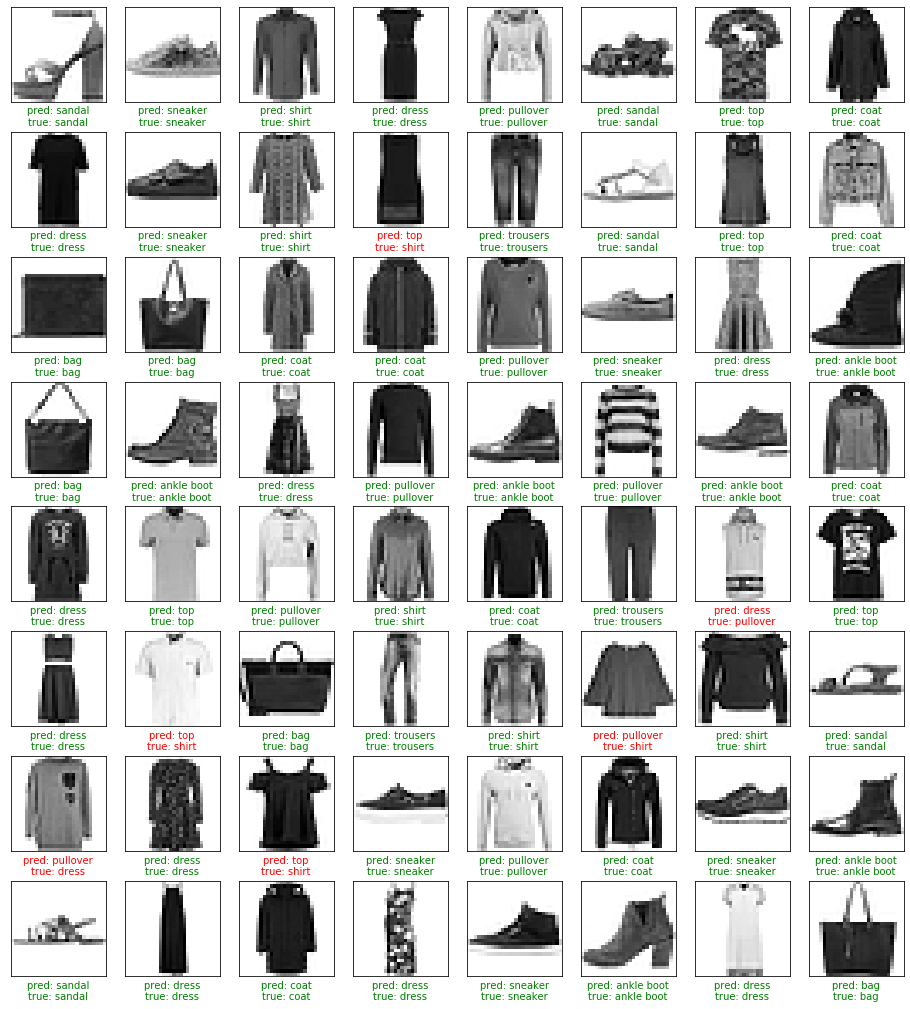

In [22]:
plot_predictions(val_y_preds['multilayer perceptron'])

In [23]:
class ConvolutionalNet(PyTorchClassifier):

    def __init__(self):
        super().__init__()
        self.layers1 = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 32, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout2d(0.25),
            torch.nn.Conv2d(32, 64, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout2d(0.25),
            torch.nn.Conv2d(64, 128, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        ])
        self.layers2 = torch.nn.ModuleList([
            torch.nn.Dropout(0.25),
            torch.nn.Linear(512, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(150, 10),
        ])

        self.loss = torch.nn.functional.cross_entropy
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, x):
        x = x.view(x.size()[0], 1, *x.size()[1:])
        for layer in self.layers1:
            x = layer(x)
        x = x.view(x.size()[0], -1)
        for layer in self.layers2:
            x = layer(x)
        return x

In [24]:
model = ConvolutionalNet()
history = model.fit(train_x, train_y, val_x, val_y)

[ 1/50] 3.2s - loss: 0.9303 - acc: 0.6552 - val_loss: 0.6024 - val_acc: 0.7624
[ 2/50] 3.4s - loss: 0.5905 - acc: 0.7802 - val_loss: 0.5149 - val_acc: 0.8100
[ 3/50] 3.2s - loss: 0.5170 - acc: 0.8102 - val_loss: 0.4362 - val_acc: 0.8386
[ 4/50] 3.1s - loss: 0.4634 - acc: 0.8311 - val_loss: 0.3993 - val_acc: 0.8522
[ 5/50] 3.1s - loss: 0.4316 - acc: 0.8421 - val_loss: 0.3671 - val_acc: 0.8640
[ 6/50] 3.1s - loss: 0.4105 - acc: 0.8500 - val_loss: 0.3497 - val_acc: 0.8692
[ 7/50] 3.1s - loss: 0.3906 - acc: 0.8559 - val_loss: 0.3392 - val_acc: 0.8722
[ 8/50] 3.1s - loss: 0.3785 - acc: 0.8607 - val_loss: 0.3256 - val_acc: 0.8752
[ 9/50] 3.1s - loss: 0.3635 - acc: 0.8667 - val_loss: 0.3248 - val_acc: 0.8754
[10/50] 3.1s - loss: 0.3540 - acc: 0.8678 - val_loss: 0.3098 - val_acc: 0.8870
[11/50] 3.1s - loss: 0.3460 - acc: 0.8733 - val_loss: 0.2974 - val_acc: 0.8886
[12/50] 3.1s - loss: 0.3337 - acc: 0.8776 - val_loss: 0.2929 - val_acc: 0.8870
[13/50] 3.1s - loss: 0.3298 - acc: 0.8779 - val_loss

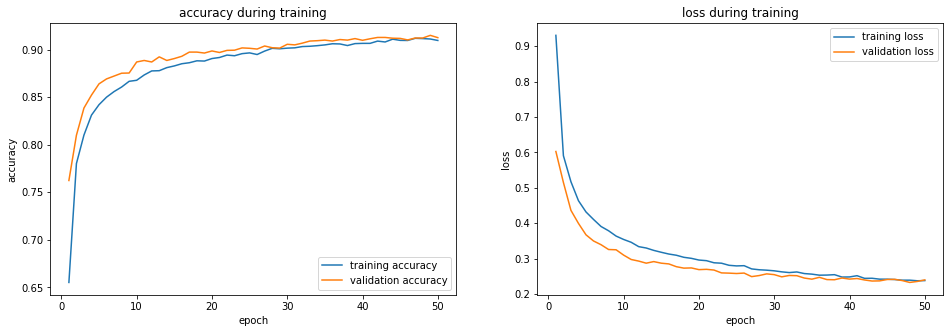

In [25]:
plot_history(history)

In [26]:
train_y_preds['convolutional net'] = model.predict(train_x)
val_y_preds['convolutional net'] = model.predict(val_x)
test_y_preds['convolutional net'] = model.predict(test_x)

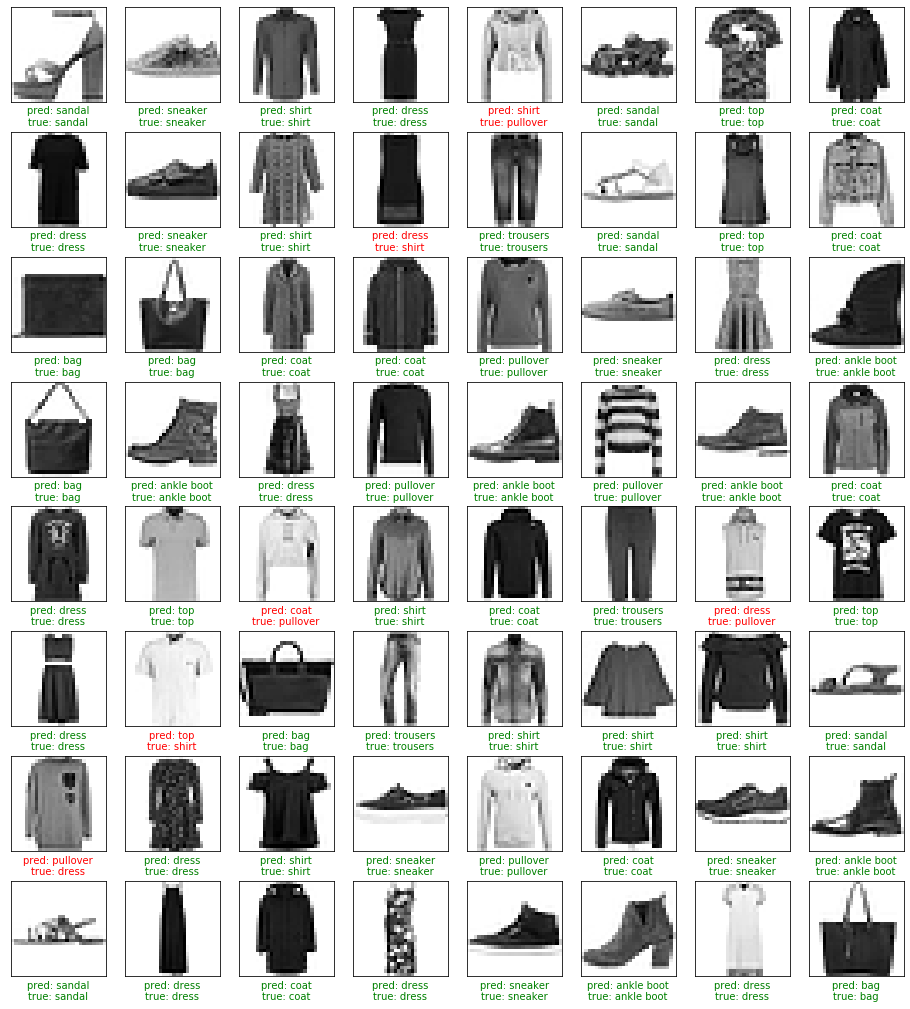

In [27]:
plot_predictions(val_y_preds['convolutional net'])

In [28]:
data = OrderedDict()
for name, y, y_preds in (
        ('training', train_y, train_y_preds),
        ('validation', val_y, val_y_preds),
        ('test', test_y, test_y_preds)):
    data[f'{name} set'] = OrderedDict([
        (m, f'{accuracy_score(y, y_pred):.3f}') for m, y_pred in y_preds.items()])
display(DataFrame(data).T)

,nearest centroid,random forest,multilayer perceptron,convolutional net
training set,0.686,0.998,0.922,0.941
validation set,0.683,0.882,0.894,0.913
test set,0.678,0.870,0.889,0.915


In [29]:
data = OrderedDict()
for name, test_y_pred in test_y_preds.items():
    precision, recall, fscore, _ = precision_recall_fscore_support(test_y, test_y_pred)
    data[(name, 'precision')] = OrderedDict([
        (labels[i], f'{s:.3f}') for i, s in enumerate(precision)])
    data[(name, 'recall')] = OrderedDict([
        (labels[i], f'{s:.3f}') for i, s in enumerate(recall)])
    data[(name, 'f-score')] = OrderedDict(
        [(labels[i], f'{s:.3f}') for i, s in enumerate(fscore)])
display(DataFrame(data))

nearest centroid                random forest                 \
                  precision recall f-score     precision recall f-score   
top                   0.711  0.685   0.698         0.818  0.850   0.834   
trousers              0.975  0.880   0.925         0.995  0.959   0.977   
pullover              0.542  0.453   0.493         0.749  0.792   0.770   
dress                 0.688  0.769   0.726         0.868  0.904   0.886   
coat                  0.516  0.565   0.540         0.762  0.805   0.783   
sandal                0.496  0.776   0.605         0.969  0.953   0.961   
shirt                 0.338  0.214   0.262         0.705  0.581   0.637   
sneaker               0.762  0.821   0.791         0.919  0.941   0.930   
bag                   0.928  0.746   0.827         0.958  0.973   0.965   
ankle boot            0.860  0.868   0.864         0.947  0.942   0.944   

           multilayer perceptron                convolutional net         \
                       precision recall f-score         precision recall   
top                        0.810  0.877   0.842             0.865  0.872   
trousers                   0.992  0.969   0.980             0.991  0.985   
pullover                   0.789  0.813   0.801             0.899  0.857   
dress                      0.873  0.924   0.898             0.912  0.918   
coat                       0.792  0.831   0.811             0.845  0.877   
sandal                     0.981  0.961   0.971             0.986  0.978   
shirt                      0.774  0.614   0.685             0.747  0.742   
sneaker                    0.937  0.966   0.951             0.957  0.977   
bag                        0.973  0.977   0.975             0.980  0.981   
ankle boot                 0.961  0.956   0.958             0.973  0.966   

                    
           f-score  
top          0.869  
trousers     0.988  
pullover     0.878  
dress        0.915  
coat         0.861  
sandal       0.982  
shirt        0.745  
sneaker      0.967  
bag          0.981  
ankle boot   0.969

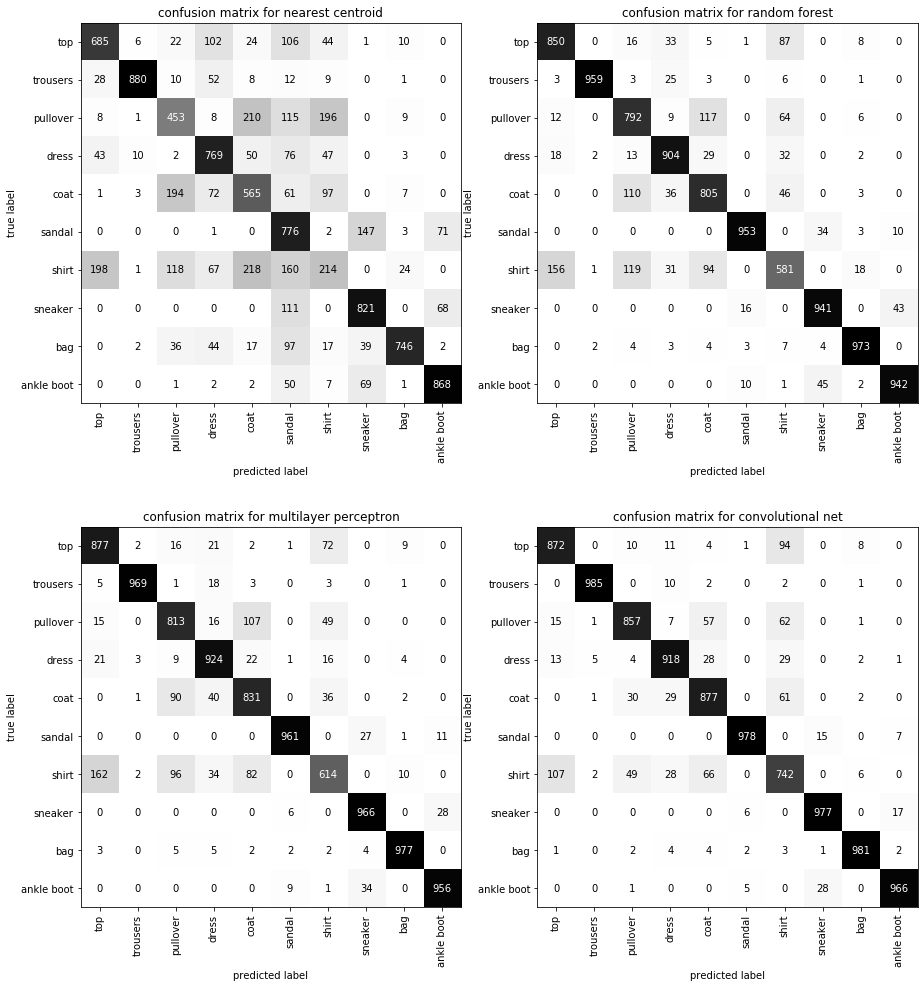

In [30]:
plt.figure(figsize=(15, 17))
for i, (name, test_y_pred) in enumerate(test_y_preds.items()):
    cm = confusion_matrix(test_y, test_y_pred)
    threshold = np.max(cm) / 2
    plt.subplot(2, 2, i + 1)
    plt.imshow(cm, cmap=plt.cm.binary)
    for i, _ in enumerate(labels):
        for j, _ in enumerate(labels):
            plt.text(
                j, i, cm[i, j], color='white' if cm[i, j] > threshold else 'black',
                horizontalalignment='center', verticalalignment='center')
    plt.title(f'confusion matrix for {name}')
    plt.xlabel('predicted label')
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.ylabel('true label')
    plt.yticks(range(len(labels)), labels)
plt.show()